# Working with your own input data

In today's class you will work with input tiles that you generate yourself. The idea is to create a few 100s of input tiles of 256x256 pixels and then feed them through the pre-trained model.

There is an example below that generates 50 tiles that have different wavelength patterns in them (I've called the dataset "random_waves" to indicate this). These are then loaded as a `SingleTileImageList` that can be fed through the model in the same way as triplets normally are. And finally we can work with the embeddings as before.

Things to work on:

- Does the neural network group tiles together with the same wave-length pattern? What if you change the number of wavelength? Or create a different kind of pattern (diagonal bands for example)?
- Try some of your own data (you can use the `to_pil_image` function below to make a grey-scale image from any 2D numpy array). How does it work on your data?

In [1]:
import convml_tt
convml_tt.__version__

'0.6.0'

## Generating synthetic anchor images for *study*

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import xarray as xr
from pathlib import Path

In [3]:
Nx = Ny = 256

x_, y_ = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
x, y = np.meshgrid(x_, y_, indexing='ij')

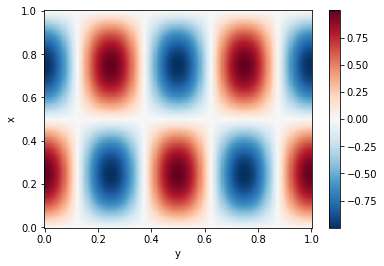

In [4]:
# example tile
arr = np.sin(x*3.14*2.)*np.cos(y*3.14*4)

da = xr.DataArray(
    arr,
    dims=('x', 'y'),
    coords=dict(x=x_, y=y_)
)

da.plot()

In [5]:
TILE_FN_FORMAT = "{tile_id:05d}_anchor.png"

def to_pil_image(arr):
    # scale values to between zero and one
    v = (arr - arr.min())/(arr.max() - arr.min())
    # scale to 0-254 and make uint for image
    im = Image.fromarray(np.uint8(v*255))
    return im

In [6]:
# make tiles with 5 different wavelengths, every time shifted 
# by a random amount in x and y

N_tiles = 50
tile_id = 0
dataset_name = "random_waves"
output_path = Path(dataset_name)
output_path.mkdir(exist_ok=True)

while tile_id < N_tiles:
    frq_x = 3.14*np.random.choice(np.arange(5))
    frq_y = 2*frq_x
    x_offset, y_offset = np.random.normal(size=2)
    arr = np.sin((x+x_offset)*frq_x)*np.cos((y+y_offset)*frq_y)

    da = xr.DataArray(
        arr,
        dims=('x', 'y'),
        coords=dict(x=x_, y=y_)
    )

    img = to_pil_image(da)
    
    fn = TILE_FN_FORMAT.format(tile_id=tile_id)
    img.save(output_path/fn)
    tile_id += 1

# Feeding through neural network

In [7]:
from convml_tt.architectures.triplet_trainer import monkey_patch_fastai
monkey_patch_fastai()

from fastai.basic_train import load_learner

In [8]:
import convml_tt

In [9]:
from convml_tt.data.sources.imagelist import SingleTileImageList

In [10]:
il = SingleTileImageList('random_waves/')

Loaded 50 image tiles


In [13]:
model = load_learner('../Nx256_s200000.0_N500study_pretrained/train/models/', file='fixednorm-stage-2.pkl')

/usr/local/Caskroom/miniconda/base/envs/convml_tt/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/Caskroom/miniconda/base/envs/convml_tt/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [14]:
da_emb = convml_tt.utils.get_embeddings(il, model)
da_emb.values = 1.0e4*da_emb.values

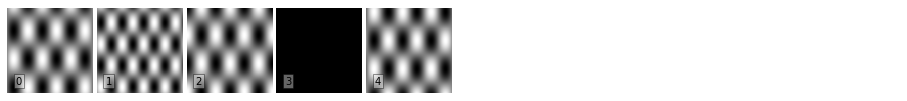

In [15]:
convml_tt.interpretation.plots.grid_overview(il, points=5)

/usr/local/Caskroom/miniconda/base/envs/convml_tt/lib/python3.7/site-packages/convml_tt/interpretation/plots/annotated_scatter_plot.py:163: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=fig.add_axes([xp-0.5*size, yh-size*0.5, size, size])


([<matplotlib.lines.Line2D at 0x1a2fe11410>,
 array([[ 0.36912 , -0.181291],
        [-0.563043, -0.303935],
        [-0.39281 ,  0.01795 ],
        [ 0.352492, -0.212742],
        [ 0.371424, -0.232882],
        [ 0.36912 , -0.181291],
        [-0.563043, -0.303935],
        [-0.39281 ,  0.01795 ],
        [-0.563043, -0.303935],
        [ 0.399626, -0.263728]], dtype=float32))

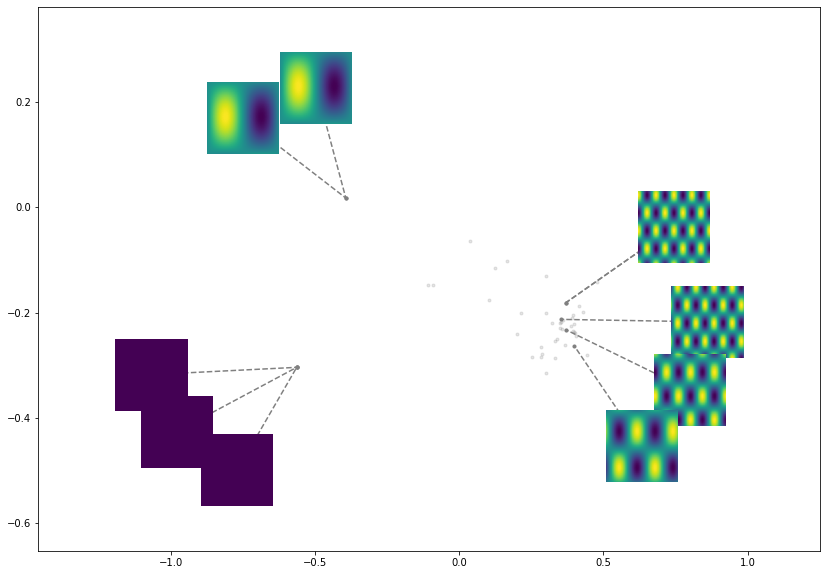

In [19]:
x = da_emb.sel(emb_dim=0)
y = da_emb.sel(emb_dim=1)
convml_tt.interpretation.plots.scatter_annotated(x, y, points=10)